# Installing Missing Components

In [1]:
#! pip install catboost
#! pip install dill
#! pip install --upgrade pip
#! pip install altair
#! pip install vega

# Loading Libraries

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import dill
import math
import random

import altair as alt
import matplotlib.pyplot as plt

from scipy.stats.stats import pearsonr
from catboost import Pool, CatBoostRegressor, cv
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV, RepeatedKFold, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

# for accessing S3 objects
# import boto3
# from sagemaker import get_execution_role

# Setting Flags

In [3]:
# setting flags
debug=False
if debug == True: 
    seed = 10 
    samples = 25000 # 25k records
else: 
    seed=np.random.randint(100000)
    samples = 100000 # 100k records

# AWS related parameters

In [4]:
#role = get_execution_role()
#bucket='nuras-play'
#train_data_key = 'rmit/math2319-machine-learning/advertising_train.csv'
#test_data_key = 'rmit/math2319-machine-learning/advertising_test.csv'
#save_data_key = 'rmit/math2319-machine-learning/saves/catboost.pkl'
#train_data_location = 's3://{}/{}'.format(bucket, train_data_key)
#test_data_location = 's3://{}/{}'.format(bucket, test_data_key)
#save_data_location = 's3://{}/{}'.format(bucket, save_data_key)

train_data_location='advertising_train.csv'
test_data_location='advertising_test.csv'
save_file = 'rf.pkl'

# Define Training and Scoring Data

In [5]:
raw_train_data = pd.read_csv(train_data_location,
                       dtype={'companyId':str,'countryId':str,'deviceType':str,'day':str,'dow':str,'price1':np.float64,
                              'price2':np.float64,'price3':np.float64,'ad_area':np.float64,'ad_ratio':np.float64,'requests':np.float64,'impression':np.float64,
                              'cpc':np.float64,'ctr':np.float64,'viewability':np.float64,'ratio1':np.float64,'ratio2':np.float64,'ratio3':np.float64,
                              'ratio4':np.float64,'ratio5':np.float64,'y':np.float64})
                             
raw_test_data = pd.read_csv(test_data_location,
                       dtype={'companyId':str,'countryId':str,'deviceType':str,'day':str,'dow':str,'price1':np.float64,
                              'price2':np.float64,'price3':np.float64,'ad_area':np.float64,'ad_ratio':np.float64,'requests':np.float64,'impression':np.float64,
                              'cpc':np.float64,'ctr':np.float64,'viewability':np.float64,'ratio1':np.float64,'ratio2':np.float64,'ratio3':np.float64,
                              'ratio4':np.float64,'ratio5':np.float64,'y':np.float64})

# Data Transformation

In [6]:
test_country = raw_test_data['countryId'].unique()
# Transform the data
trans_train_data = raw_train_data.copy()
for float_cols in trans_train_data.select_dtypes('float').columns:
    trans_train_data[float_cols] = 1/np.sqrt((trans_train_data[float_cols]+0.5))

# Transform the data
trans_test_data = raw_test_data.copy()
for float_cols in trans_test_data.select_dtypes('float').columns:
    trans_test_data[float_cols] = 1/np.sqrt((trans_test_data[float_cols]+0.5))   
    
print(trans_train_data.shape)
trans_train_data = trans_train_data[trans_train_data.countryId.isin(test_country)]
print(trans_train_data.shape)

(214128, 21)
(213534, 21)


# Split as Test and Train

In [7]:
trans_train_data_x = trans_train_data[['companyId','countryId','deviceType','day','dow','price1','price2','price3','ad_area','ad_ratio','requests',
                                       'impression','cpc','ctr','viewability','ratio1','ratio2','ratio3','ratio4','ratio5']]
trans_train_data_x['label'] = 'train'
trans_train_data_y = trans_train_data['y']
if debug == True: print("Shape of trans_train_data_x " + str(trans_train_data_x.shape))


trans_test_data_x = trans_test_data[['companyId','countryId','deviceType','day','dow','price1','price2','price3','ad_area','ad_ratio','requests',
                                       'impression','cpc','ctr','viewability','ratio1','ratio2','ratio3','ratio4','ratio5']]
trans_test_data_x['label'] = 'test'
if debug == True: print("Shape of trans_test_data_x " + str(trans_test_data_x.shape))

all_x = pd.concat([trans_train_data_x,trans_test_data_x], ignore_index=True)
if debug == True: print("Shape of all_x " + str(all_x.shape))


In [8]:
one_hot = pd.get_dummies(all_x[['companyId','countryId','deviceType','day','dow']], drop_first=True)
if debug == True: print("Shape of one_hot after 1 hot encoding" + str(one_hot.shape))

# Drop columns already encoded
all_x = all_x.drop(['companyId','countryId','deviceType','day','dow'],axis = 1)
if debug == True: print("Shape of all_x after dropping categorical" + str(all_x.shape))

# Join the encoded df
all_x = all_x.join(one_hot)
if debug == True: print("Shape of all_x after 1 hot encoding and removing categorical feat"+ str(all_x.shape))

# split test and train again
new_trans_train_x = all_x[all_x['label'] == 'train'].drop(['label'],axis = 1)
if debug == True: print("Final shape of train X data"+ str(new_trans_train_x.shape))
    
new_trans_test_x = all_x[all_x['label'] == 'test'].drop(['label'],axis = 1)
if debug == True: print("Final shape of test X data"+ str(new_trans_test_x.shape))

# Defining debugging and normal parameters

In [9]:
def inv_trans(y_val):
    return((1 / np.square(y_val)) - 0.5)

In [10]:
def mse_calc(y_true,y_pred):
    mse = mean_squared_error(inv_trans(y_true), inv_trans(y_pred))
    print (mse)
    return mse

In [11]:
model = RandomForestRegressor()
    
if debug == True: 
    cv_method = RepeatedKFold(n_splits=3, n_repeats=1,random_state=seed)
    parameters = {'n_estimators'  : [10,20],
                  'bootstrap'     : ['True','False'],
                  'max_depth'     : [10,30],
                  'min_samples_leaf' : [2,5,7]
                  #'random_state'  : seed
                 }
else: 
    cv_method = RepeatedKFold(n_splits=5, n_repeats=3,random_state=seed)
    parameters = {'n_estimators'  : [20,30,40,50,100],
                  'bootstrap'     : ['True','False'],
                  'max_depth'     : [5,10,20,30],
                  'min_samples_leaf' : [2,5,7]
                  #'random_state'  : seed
                 }

# Hyper Parameter Tuning

In [12]:
#grid = GridSearchCV(estimator=model, param_grid = parameters, 
#                  scoring = make_scorer(mse_calc, greater_is_better=False)  ,cv = cv_method, n_jobs=-1,
#                    return_train_score=True)
#grid.fit(new_trans_train_x.sample(samples, random_state = seed),trans_train_data_y.sample(samples, random_state = seed))
#neg_mean_squared_error
grid = GridSearchCV(estimator=model, param_grid = parameters, 
                    scoring = 'neg_mean_squared_error'  ,cv = cv_method, n_jobs=3,
                    return_train_score=True)
grid.fit(new_trans_train_x.sample(samples, random_state = seed),trans_train_data_y.sample(samples, random_state = seed))


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x000001AA64889438>,
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'n_estimators': [20, 30, 40, 50, 100], 'bootstrap': ['True', 'False'], 'max_depth': [5, 10, 20, 30], 'min_samples_leaf': [2, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [13]:
results_DT = pd.DataFrame(grid.cv_results_['params'])
results_DT['test_score'] = grid.cv_results_['mean_test_score']
results_DT.columns
results_DT

bootstrap  max_depth  min_samples_leaf  n_estimators  test_score
0        True          5                 2            20   -0.038011
1        True          5                 2            30   -0.037838
2        True          5                 2            40   -0.037860
3        True          5                 2            50   -0.037783
4        True          5                 2           100   -0.037750
5        True          5                 5            20   -0.038085
6        True          5                 5            30   -0.037871
7        True          5                 5            40   -0.037841
8        True          5                 5            50   -0.037793
9        True          5                 5           100   -0.037765
10       True          5                 7            20   -0.037924
11       True          5                 7            30   -0.037881
12       True          5                 7            40   -0.037769
13       True          5                 7            50   -0.037775
14       True          5                 7           100   -0.037803
15       True         10                 2            20   -0.025012
16       True         10                 2            30   -0.024976
17       True         10                 2            40   -0.024895
18       True         10                 2            50   -0.024911
19       True         10                 2           100   -0.024838
20       True         10                 5            20   -0.025022
21       True         10                 5            30   -0.024960
22       True         10                 5            40   -0.024934
23       True         10                 5            50   -0.024951
24       True         10                 5           100   -0.024893
25       True         10                 7            20   -0.025118
26       True         10                 7            30   -0.025004
27       True         10                 7            40   -0.024988
28       True         10                 7            50   -0.024963
29       True         10                 7           100   -0.024916
..        ...        ...               ...           ...         ...
90      False         20                 2            20   -0.020399
91      False         20                 2            30   -0.020216
92      False         20                 2            40   -0.020158
93      False         20                 2            50   -0.020138
94      False         20                 2           100   -0.020027
95      False         20                 5            20   -0.020594
96      False         20                 5            30   -0.020473
97      False         20                 5            40   -0.020403
98      False         20                 5            50   -0.020373
99      False         20                 5           100   -0.020302
100     False         20                 7            20   -0.020812
101     False         20                 7            30   -0.020685
102     False         20                 7            40   -0.020652
103     False         20                 7            50   -0.020629
104     False         20                 7           100   -0.020559
105     False         30                 2            20   -0.019792
106     False         30                 2            30   -0.019568
107     False         30                 2            40   -0.019478
108     False         30                 2            50   -0.019416
109     False         30                 2           100   -0.019300
110     False         30                 5            20   -0.019892
111     False         30                 5            30   -0.019737
112     False         30                 5            40   -0.019672
113     False         30                 5            50   -0.019628
114     False         30                 5           100   -0.019551
115     False         30                 7            20   -0.020116
11

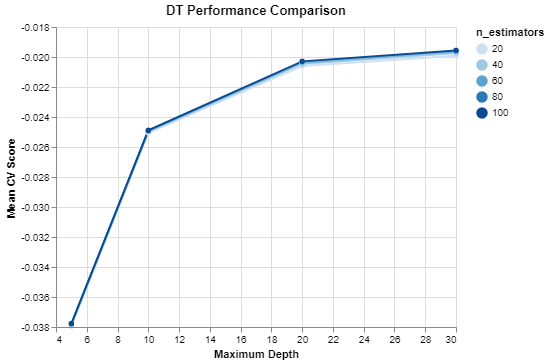

In [14]:
alt.renderers.enable('notebook')
alt.Chart(results_DT, 
          title='DT Performance Comparison'
         ).mark_line(point=True).encode(
    alt.X('max_depth', title='Maximum Depth'),
    alt.Y('test_score', title='Mean CV Score', aggregate='average', scale=alt.Scale(zero=False)),
    color='n_estimators'
)

# Results

In [15]:
# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)
print("\n The best score across ALL searched params:\n",grid.best_score_)
print("\n The best parameters across ALL searched params:\n",grid.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(bootstrap='False', criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

 The best score across ALL searched params:
 -0.019299609689204227

 The best parameters across ALL searched params:
 {'bootstrap': 'False', 'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 100}



In [16]:
#s3 = boto3.resource('s3')
#s3.Bucket(save_data_location).put_object(key="catboost_data", data=dill.dump_session())
#s3.Bucket(bucket).put_object(Key=key, Body=data)
#dill.dump_session(save_data_location)

# Running Finalised Model

In [17]:
model = RandomForestRegressor(bootstrap= False, max_depth= 30, n_estimators= 20)
model.fit(new_trans_train_x,trans_train_data_y)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# Score Model

In [18]:
# make the prediction using the resulting model
preds = model.predict(new_trans_test_x)

In [19]:
inv_transform = (1 / np.square(preds)) - 0.5
inv_transform[0:10]

array([0.47938173, 1.00362162, 1.89465867, 0.08077081, 0.09609344,
       1.115     , 2.06970422, 0.27451317, 0.54820325, 0.46342757])

# Feature Importance

In [20]:
#from catboost import FeatureImportance
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), list(new_trans_train_x)), reverse=True))

Features sorted by their score:
[(0.2301, 'ctr'), (0.1977, 'cpc'), (0.0898, 'price2'), (0.0515, 'price1'), (0.0511, 'ratio2'), (0.0456, 'price3'), (0.0313, 'requests'), (0.0231, 'impression'), (0.0193, 'ad_area'), (0.018, 'companyId_40'), (0.0173, 'viewability'), (0.0156, 'ratio1'), (0.0124, 'companyId_159'), (0.0124, 'ad_ratio'), (0.0093, 'companyId_43'), (0.0091, 'countryId_234'), (0.0083, 'deviceType_2'), (0.0062, 'deviceType_3'), (0.0056, 'companyId_95'), (0.0049, 'ratio5'), (0.0046, 'countryId_17'), (0.0042, 'countryId_38'), (0.0041, 'ratio4'), (0.004, 'countryId_43'), (0.004, 'countryId_13'), (0.0039, 'countryId_98'), (0.0038, 'countryId_57'), (0.0037, 'countryId_77'), (0.0036, 'countryId_190'), (0.0033, 'ratio3'), (0.0027, 'countryId_171'), (0.0026, 'countryId_200'), (0.0026, 'countryId_12'), (0.0022, 'countryId_75'), (0.0021, 'countryId_59'), (0.002, 'deviceType_5'), (0.002, 'day_21.0'), (0.0019, 'countryId_56'), (0.0019, 'countryId_20'), (0.0019, 'countryId_166'), (0.0019, 'co

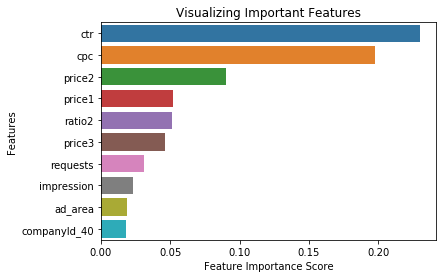

In [21]:
feature_imp = pd.Series(model.feature_importances_.round(3),index=list(new_trans_train_x)).sort_values(ascending=False)
# Creating a bar plot
feature_imp_h = feature_imp.head(10)
sns.barplot(x=feature_imp_h, y=feature_imp_h.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [22]:
filename = 'rf.pkl'
dill.dump_session(filename)
